In [1]:
!pip install git+https://github.com/python-graphblas/python-graphblas

  Cloning https://github.com/python-graphblas/python-graphblas to /tmp/pip-req-build-81jju4zc
  Running command git clone --filter=blob:none --quiet https://github.com/python-graphblas/python-graphblas /tmp/pip-req-build-81jju4zc
  Resolved https://github.com/python-graphblas/python-graphblas to commit 27b23e414a9a73daa9c3dda9698e227562d9a18c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 19.5 MB/s eta 0:00:00
  Created wheel for python-graphblas: filename=python_graphblas-2024.2.0+2.g27b23e41-py3-none-any.whl size=351142 sha256=a78f146d8c2618817897dcac7af274a067943bcdd8c5dee5280e745bd7bd2222
  Stored in directory: /tmp/pip-ephem-wheel-cache-rtz6o5s0/wheels/1d/ff/e1/7abbc85fde1376805d105bcb709a635cac5d6fcf1cc6f7d3ad
Successfully built python-graphblas


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

In [3]:
def BellmanFord(m, start_vertex):
  v = Vector(m.dtype, m.nrows)
  v[start_vertex] << 0
  w = v.dup()
  for i in range(m.nrows-1):
    w_old = w.dup()
    w(binary.min) << w.vxm(m, semiring.min_plus)
    if w.isequal(w_old):
        break
  #проверка на цикл отрицательного веса
  w_old = w.dup()
  w(binary.min) << w.vxm(m, semiring.min_plus)
  if not w.isequal(w_old):
    raise Exception("Ошибка: в графе есть цикл отрицательного веса")
  #формирую ответ
  ar_val=[]
  for i in range(m.nrows):
    if w[i].value is None:
      ar_val.append(float('inf'))
    else:
      ar_val.append(w[i].value)
  return ar_val

In [4]:
def BellmanFordModify(m, start_vertex_ar):
  rows=start_vertex_ar.size
  cols=m.ncols
  v = Matrix(dtypes.INT32, rows, cols)
  for i in range(rows):
    v[i,start_vertex_ar[i]] << 0
  w = v.dup()
  for i in range(cols-1):
    w_old = w.dup()
    for i in range(rows):
      w[i,:](binary.min) << w[i,:].vxm(m, semiring.min_plus)
    if w.isequal(w_old):
        break
  #проверка на цикл отрицательного веса
  w_old = w.dup()
  for i in range(rows):
    w[i,:](binary.min) << w[i,:].vxm(m, semiring.min_plus)
  if not w.isequal(w_old):
    raise Exception("Ошибка: в графе есть цикл отрицательного веса")
  #формирую ответ
  output = {}
  for i in range(rows):
    ar_val=[]
    for j in range(cols):
      if w[i,j].value is None:
        ar_val.append(float('inf'))
      else:
        ar_val.append(w[i,j].value)
    output[start_vertex_ar[i]]=np.array(ar_val)
  return output

In [28]:
def FloydWarshall(m):
  D=m.dup()
  rows=m.nrows
  cur_D=m.dup()
  for k in range(rows):
    #ввожу переменные-матрицы для удобства умножения далее
    D_col=Matrix(dtypes.INT32, rows, rows)
    D_row=Matrix(dtypes.INT32, rows, rows)
    D_col[:,k]=D[:,k].dup()
    D_row[k,:]=D[k,:].dup()
    cur_D << D_col.mxm(D_row, semiring.min_plus)
    #считаю None-значения как бесконечно большие
    D << D.ewise_add(cur_D, op="min")
  #проверяю наличие циклов с отрицательным весом
  D1=D.dup()
  cur_D1=cur_D.dup()
  D_col1=Matrix(dtypes.INT32, rows, rows)
  D_row1=Matrix(dtypes.INT32, rows, rows)
  D_col1[:,k]=D1[:,k].dup()
  D_row1[k,:]=D1[k,:].dup()
  cur_D1 << D_col1.mxm(D_row1, semiring.min_plus)
  D1 << D1.ewise_add(cur_D1, op="min")
  if not D1.isequal(D):
    raise Exception("Ошибка: в графе есть цикл отрицательного веса")
  #формирую ответ
  output = {}
  for i in range(rows):
    ar_val=[]
    for j in range(rows):
      if i==j:
        ar_val.append(0)
      elif D[i,j].value is None:
        ar_val.append(float('inf'))
      else:
        ar_val.append(D[i,j].value)
    output[i]=np.array(ar_val)
  return output

In [21]:
def TransitiveClosure(m):
  rows=m.nrows
  I=Matrix(dtypes.INT32, rows, rows)
  for i in range(rows):
    I[i,i] << 1
  D=I.dup()
  for i in range(rows):
    D1=D.dup()
    D=D.mxm(m, semiring.min_plus).ewise_add(I, op="min")
    if D1.isequal(D):
      break
  D2=D.dup()
  D2=D2.mxm(m, semiring.min_plus).ewise_add(I, op="min")
  if not D2.isequal(D):
    raise Exception("Ошибка: в графе есть цикл отрицательного веса")
  #формирую ответ
  output = {}
  for i in range(rows):
    ar_val=[]
    for j in range(rows):
      if D[i,j].value is None:
        ar_val.append(float('inf'))
      elif i==j:
        ar_val.append(0)
      else:
        ar_val.append(D[i,j].value-1)
    output[i]=np.array(ar_val)
  return output

**Тестирование решений**

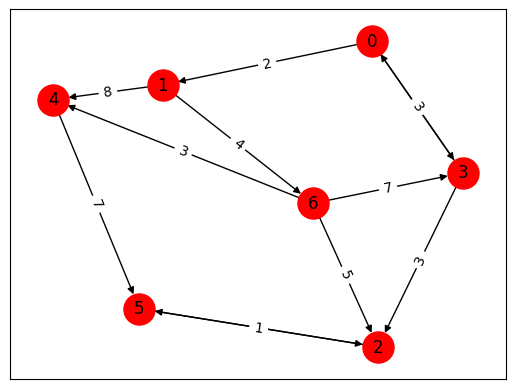

BellmanFord:
[14, 0, 9, 11, 7, 10, 4]
[inf, inf, 0, inf, inf, 1, inf]
[3, 5, 3, 0, 12, 4, 9]
BellmanFordModify:
{1: array([14,  0,  9, 11,  7, 10,  4]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3,  5,  3,  0, 12,  4,  9])}
FloydWarshall:
{0: array([0, 2, 6, 3, 9, 7, 6]), 1: array([14,  0,  9, 11,  7, 10,  4]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3,  5,  3,  0, 12,  4,  9]), 4: array([inf, inf,  8., inf,  0.,  7., inf]), 5: array([inf, inf,  1., inf, inf,  0., inf]), 6: array([10, 12,  5,  7,  3,  6,  0])}
TransitiveClosure:
{0: array([0, 2, 6, 3, 9, 7, 6]), 1: array([14,  0,  9, 11,  7, 10,  4]), 2: array([inf, inf,  0., inf, inf,  1., inf]), 3: array([ 3,  5,  3,  0, 12,  4,  9]), 4: array([inf, inf,  8., inf,  0.,  7., inf]), 5: array([inf, inf,  1., inf, inf,  0., inf]), 6: array([10, 12,  5,  7,  3,  6,  0])}


In [29]:
import numpy as np
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(m)

#Для Беллман-Форда:
#При обходе из вершины 1: до 6 прямой путь кратчайший - 4; до 4 вершины из вариантов 1-6-4 и 1-4
#короче вариант 1-6-4, он равен 7; до нулевой вершины путь 1-6-3-0 длиной 14; до вершины 2
#путь 1-6-2 длиной 9; до вершины 3 путь 1-6-3 длиной 11, до вершины 5 короче будет путь 1-6-2-5 длиной 10.
print('BellmanFord:')
print(BellmanFord(m, 1))
#При обходе из вершины 2 достижима только вершина 5, путь длиной 1. Остальные вершины недостижимы.
print(BellmanFord(m, 2))
#При обходе из вершины 3: до 0 и 2 путь кратчайший прямой - длинами 3 и 3 соответственно; до 1 путь через 0
#длиной 5; до 6 самый короткий путь - 3-0-1-6 длиной 9; до 4 ближе будет через 6ку, вычисленную ранее - получится
#путь длиной 12; до 5ки путь через 2ку - длина 4.
print(BellmanFord(m, 3))
print('BellmanFordModify:')
print(BellmanFordModify(m, np.array([1,2,3])))
print('FloydWarshall:')
print(FloydWarshall(m))
print('TransitiveClosure:')
print(TransitiveClosure(m))

In [30]:
#Для проверки закину в модификацию Беллмана-Форда массив этих же вершин и сравню результаты поэлементно.
assert (BellmanFordModify(m, np.array([1,2,3]))[1]==BellmanFord(m, 1)).all()
assert (BellmanFordModify(m, np.array([1,2,3]))[2]==BellmanFord(m, 2)).all()
assert (BellmanFordModify(m, np.array([1,2,3]))[3]==BellmanFord(m, 3)).all()
#Также для этих вершин сравню результаты с Флойд-Варшаллом
assert (FloydWarshall(m)[1]==BellmanFord(m, 1)).all()
assert (FloydWarshall(m)[2]==BellmanFord(m, 2)).all()
assert (FloydWarshall(m)[3]==BellmanFord(m, 3)).all()
#Сравню результаты алгоритмов Флойда-Варшала и транзитивного замыкания
assert (FloydWarshall(m)[0]==TransitiveClosure(m)[0]).all()
assert (FloydWarshall(m)[1]==TransitiveClosure(m)[1]).all()
assert (FloydWarshall(m)[2]==TransitiveClosure(m)[2]).all()
assert (FloydWarshall(m)[3]==TransitiveClosure(m)[3]).all()
assert (FloydWarshall(m)[4]==TransitiveClosure(m)[4]).all()
assert (FloydWarshall(m)[5]==TransitiveClosure(m)[5]).all()
assert (FloydWarshall(m)[6]==TransitiveClosure(m)[6]).all()

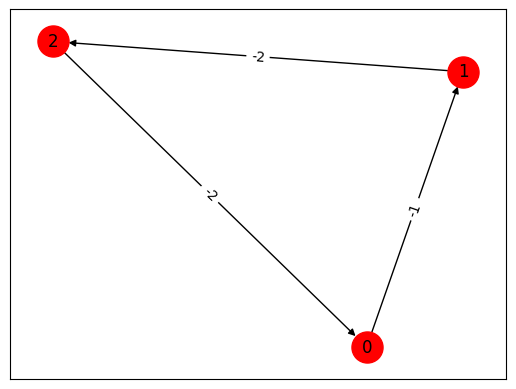

In [17]:
#Проверю функции на графе с циклом отрицательного веса (должны вернуть ошибку)
M1=gb.Matrix.from_coo(
    [0, 1, 2],
    [1, 2, 0],
    [-1,-2,-2],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

In [ ]:
print(BellmanFord(M1, 2))

Exception: Ошибка: в графе есть цикл отрицательного веса

In [ ]:
print(BellmanFordModify(M1, np.array([0,2])))

Exception: Ошибка: в графе есть цикл отрицательного веса

In [ ]:
print(FloydWarshall(M1))

Exception: Ошибка: в графе есть цикл отрицательного веса

In [20]:
print(TransitiveClosure(M1))

Exception: Ошибка: в графе есть цикл отрицательного веса